**Possion equation in 1D with Dirichlet/Robin boundary conditions**

Retyped by Theodoret Putra Agatho on 7 Aug. 2023

[Source](https://deepxde.readthedocs.io/en/latest/demos/pinn_forward/poisson.1d.dirichletrobin.html)

In [1]:
pip install deepxde

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 165.3/165.3 kB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.3/100.3 kB 5.9 MB/s eta 0:00:00


**Problem setup**

We will solve a Poisson equation:

\begin{align}
        \Delta u = 2, x \in [-1, 1],
    \end{align}

with the Robin boundary conditions on the right boundary

\begin{align}
        \frac{\partial u}{\partial x} = u
    \end{align}

and Dirichlet boundary conditions on the left boundary

\begin{align}
        u(-1) = 0.
    \end{align}

The exact solution is $u(x) = (x + 1)^2$.

**Implementation**

This description goes through the implementation of a solver for the above described Poisson equation step-by-step. First, the DeepXDE module is imported:

In [2]:
import deepxde as dde
import numpy as np

No backend selected.
Finding available backend...


Using backend: tensorflow.compat.v1
Other supported backends: tensorflow, pytorch, jax, paddle.
paddle supports more examples now and is recommended.
Instructions for updating:
non-resource variables are not supported in the long term


Found tensorflow.compat.v1
Setting the default backend to "tensorflow.compat.v1". You can change it in the ~/.deepxde/config.json file or export the DDE_BACKEND environment variable. Valid options are: tensorflow.compat.v1, tensorflow, pytorch, jax, paddle (all lowercase)


We begin by defining a computational geometry. We can use a built-in class `Interval` as follows

In [3]:
geom = dde.geometry.Interval(-1, 1)

Next, we express the PDE residual of the Poisson equation:

In [4]:
def pde(x, y):
  dy_xx = dde.grad.hessian(y, x)
  return dy_xx - 2

The first argument to `pde` is the network input, i.e., the $x$-coordinate. The second argument is the network output, i.e., the solution $u(x)$, but here we use `y` as the name of the variable.

Next, we consider the Robin boundary condition and Dirichlet boundary condition respectively.

The location of the Robin boundary condition is defined by a simple Python function. The function should return `True` for those points satisfying $x = 1$ and `False` otherwise (Note that because of rounding-off errors, it is often wise to use `dde.utils.isclose` to test whether two floating point values are equivalent). In this function, the argument `x` to `boundary` is the network input and is a $d$-dim vector, where $d$ is the dimension and $d = 1$ in this case. Then a boolean `on_boundary` is used as the second argument. If the point `x` (the first argument) is on the boundary of the geometry, in this case Robin boundary when it reaches the right endpoint of the interval, then `on_boundary` is `True`, otherwise, `on_boundary` is `False`.

In [6]:
def boundary_r(x, on_boundary):
  return on_boundary and dde.utils.isclose(x[0], 1)

The location of the Dirichlet boundary condition is defined in a similar way that the function should return `True` for those points satisfying $x = -1$ and `False` otherwise. The arguments in this function are similar to `boundary_r`, and the only difference is that in this case Dirichlet boundary condition is used when it reaches the left endpoint of the interval.

In [7]:
def boundary_l(x, on_boundary):
  return on_boundary and dde.utils.isclose(x[0], -1)

Next, we define a function to return the value of $u(x)$ for the points $x$ on the Dirichlet boundary. In this case, it is $u(x) = 0$. For example, $(x + 1)^2$ is 0 on the boundary, and thus we can also use

In [8]:
def func(x):
  return (x + 1) ** 2

Then, the Dirichlet boundary condition is

In [11]:
bc_l = dde.icbc.DirichletBC(geom, func, boundary_l)

For Robin boundary condition, rather than define a function to return the value of $u(x)$ on the boundary, we use a lambda function that maps `x` and `y` to `y`, where x is the input and y is the output. Then Robin boundary condition is defined

In [10]:
bc_r = dde.icbc.RobinBC(geom, lambda X, y: y, boundary_r)

Now, we have specified the geometry, PDE residual, Dirichlet boundary condition, and Robin boundary condition. We then define the PDE problem as

In [12]:
data = dde.data.PDE(geom, pde, [bc_l, bc_r], 16, 2, solution=func, num_test=100)

The number 16 is the number of training residual points sampled inside the domain, and the number 2 is the number of training points sampled on the boundary. The argument `solution=func` is the reference solution to compute the error of our solution, and can be ignored if we don't have a reference solution. We use 100 residual points for testing the PDE residual.

Next, we choose the network. Here, we use a fully connected neural network of depth 4 (i.e., 3 hidden layers) and width 50:

In [13]:
layer_size = [1] + [50] * 3 + [1]
activation = "tanh"
initializer = "Glorot uniform"
net = dde.nn.FNN(layer_size, activation, initializer)

Now, we have the PDE problem and the network. We build a `Model` and choose the optimizer and learning rate:

In [14]:
model = dde.Model(data, net)
model.compile("adam", lr=0.001, metrics=["l2 relative error"])

Compiling model...
Building feed-forward neural network...
'build' took 0.160449 s



/usr/local/lib/python3.10/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 0.763584 s



We also compute the $L^2$ relative error as a metric during training.

We then train the model for 10000 iterations:

In [15]:
losshistory, train_state = model.train(iterations=10000)

Training model...

Step      Train loss                        Test loss                         Test metric   
0         [4.00e+00, 1.08e-02, 1.06e-04]    [4.00e+00, 1.08e-02, 1.06e-04]    [9.78e-01]    
1000      [3.58e-05, 1.23e-05, 2.65e-06]    [2.55e-05, 1.23e-05, 2.65e-06]    [1.09e-03]    
2000      [1.12e-05, 1.34e-07, 1.02e-06]    [1.22e-05, 1.34e-07, 1.02e-06]    [2.27e-04]    
3000      [8.73e-06, 3.52e-09, 9.46e-09]    [9.25e-06, 3.52e-09, 9.46e-09]    [3.09e-04]    
4000      [1.88e-05, 1.03e-05, 3.81e-05]    [1.66e-05, 1.03e-05, 3.81e-05]    [2.04e-03]    
5000      [7.04e-06, 1.36e-07, 5.76e-07]    [8.08e-06, 1.36e-07, 5.76e-07]    [1.91e-04]    
6000      [6.20e-06, 9.38e-09, 5.44e-08]    [7.07e-06, 9.38e-09, 5.44e-08]    [2.56e-04]    
7000      [5.50e-06, 1.16e-08, 3.23e-08]    [6.23e-06, 1.16e-08, 3.23e-08]    [2.36e-04]    
8000      [4.72e-06, 1.23e-09, 4.39e-09]    [5.49e-06, 1.23e-09, 4.39e-09]    [2.52e-04]    
9000      [1.78e-05, 1.22e-05, 2.68e-05]    [1.42e-

Saving loss history to /content/loss.dat ...
Saving training data to /content/train.dat ...
Saving test data to /content/test.dat ...


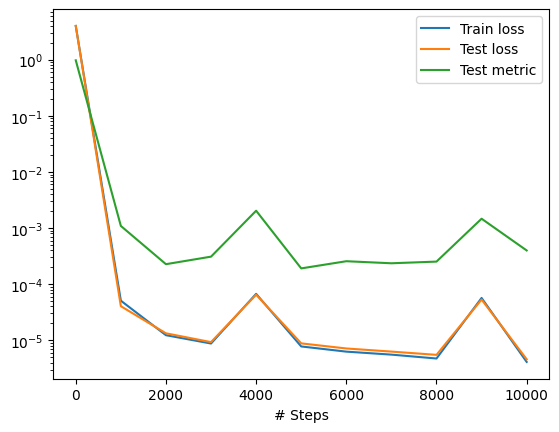

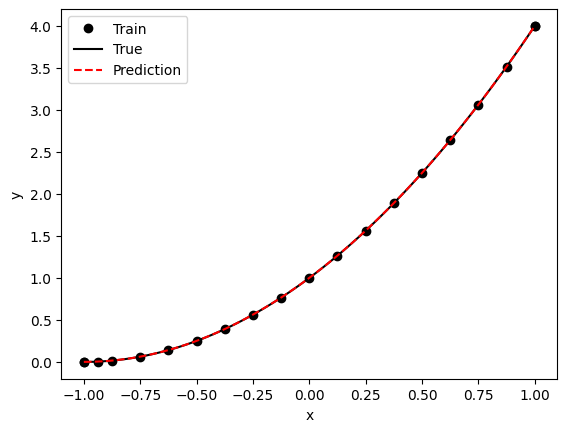

In [16]:
dde.saveplot(losshistory, train_state, issave=True, isplot=True)